# read data

In [1]:
# glob can is used to load files easily
import glob
import os
txt_file_path = "song_lyrics/*"
txt_lst = glob.glob(txt_file_path)
print(len(txt_lst))
print(txt_lst[:10])

49
['song_lyrics/britney-spears.txt', 'song_lyrics/bieber.txt', 'song_lyrics/lin-manuel-miranda.txt', 'song_lyrics/bjork.txt', 'song_lyrics/jimi-hendrix.txt', 'song_lyrics/blink-182.txt', 'song_lyrics/amy-winehouse.txt', 'song_lyrics/radiohead.txt', 'song_lyrics/r-kelly.txt', 'song_lyrics/paul-simon.txt']


In [2]:
raw_corpus = []

# read all txt_lst
for txt_file in txt_lst:
    #open text file, read, and then add into raw_corpus
    with open(txt_file, "r") as f:
        #read().splitlines() : read all lines and split it by \n
        try:
            raw = f.read().splitlines()
            #add all lines into list seperately
            raw_corpus.extend(raw)
        except UnicodeDecodeError as e:
            print("current txt_file : ", txt_file)
            print(e)
            

print("length of raw_corpus : ", len(raw_corpus))
print("examples : \n",raw_corpus[:2])

length of raw_corpus :  187088
examples : 
 ['They say get ready for the revolution', "I think it's time we find some sorta solution"]


# data preprocessing
- basic : delete duplicates and null
- natural language processing : replacing special charater/blank, tokenization, word 2 index

In [3]:
import re
import random

def preprocess_sentence(raw_sentence):
    low_sentence = raw_sentence.lower().strip()
    special_space_sentence = re.sub(r"([?.!,¿])",r" \1 ", low_sentence)
    empty_space_sentence = re.sub(r'[" "]+', " ", special_space_sentence)
    all_space_sentence = re.sub(r"[^a-zA-Z?.!,¿]+"," ", empty_space_sentence)
    striped_sentence = all_space_sentence.strip()
    if len(striped_sentence) == 0:
        return None
    sentence = "<start> " + striped_sentence + " <end>"
    return sentence


idx = int(random.random() * 100)
selected_sentence = raw_corpus[idx]
preprocessed_sentence = preprocess_sentence(selected_sentence)
print("### comparision raw sentence and preprocessed sentence ###")
print("selected sentence : ", selected_sentence)
print("after preprocessing : ", preprocessed_sentence)

### comparision raw sentence and preprocessed sentence ###
selected sentence :  Anywhere you wanna
after preprocessing :  <start> anywhere you wanna <end>


In [4]:
idx = int(random.random() * 100)
length = 20
print("### comparision raw sentence and preprocessed sentence ###")
for i in range(idx, idx + length):
    selected_sentence = raw_corpus[i]
    preprocessed_sentence = preprocess_sentence(selected_sentence)
    #print("selected sentence : ", selected_sentence)
    print("after preprocessing : ", preprocessed_sentence)

### comparision raw sentence and preprocessed sentence ###
after preprocessing :  <start> it s like a competition <end>
after preprocessing :  <start> me against the beat <end>
after preprocessing :  <start> i want to get in the zone <end>
after preprocessing :  <start> i want to get in the zone if you really want to party <end>
after preprocessing :  <start> settle up and get your rhythm <end>
after preprocessing :  <start> try to hit , you could die <end>
after preprocessing :  <start> in a minute , i ma take a ya on , i ma take a ya on <end>
after preprocessing :  <start> hey , hey , hey here we go all my people on the floor let me see you dance <end>
after preprocessing :  <start> all my people up for more let me see you dance <end>
after preprocessing :  <start> all my people , round and round let me see you dance <end>
after preprocessing :  <start> all my people in the crowd , let me see you dance <end>
after preprocessing :  <start> i wanna see you get on the floor <end>
after 

In [5]:
corpus = []
for sentence in raw_corpus:
    # if sentence is empty, pass
    if len(sentence) == 0: continue
    preprocessed = preprocess_sentence(sentence)
    if preprocessed != None and len(preprocessed) != 0:
        corpus.append(preprocessed)

print(len(corpus))
print("### print 5 preprocessed sentences ##")
print(corpus[:5])

175933
### print 5 preprocessed sentences ##
['<start> they say get ready for the revolution <end>', '<start> i think it s time we find some sorta solution <end>', '<start> somebody s caught up in the endless pollution <end>', '<start> they need to wake up , stop living illusions i know you need to hear this <end>', '<start> why won t somebody feel this <end>']


In [6]:
import tensorflow as tf

def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000,
        filters='',
        oov_token="<unk>"
    )
    tokenizer.fit_on_texts(corpus)
    
    tensor = tokenizer.texts_to_sequences(corpus)
    # token이 너무 크면 공백이 많아지므로 최대 길이를 15로 지정
    # 마지막 단어가 출력에 가까운게 좋으므로 앞에 패딩을 뭍임
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, maxlen=15,padding="post")
    print("tensor.shape : ", tensor.shape)
    print(tensor, tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

tensor.shape :  (175933, 15)
[[   2   45   68 ...    0    0    0]
 [   2    5  127 ...    0    0    0]
 [   2  265   16 ...    0    0    0]
 ...
 [   2    7  224 ...    0    0    0]
 [  19  144    4 ...   19  887    3]
 [   2    8 3435 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f60c41bfa10>


In [7]:
# print tensor and tokenizer's values
print(tensor[:3, :])
print(type(tokenizer.index_word))
print(tokenizer.word_index[','])
print(tokenizer.word_index['.'])
print(tokenizer.word_index['?'])

for idx in tokenizer.index_word:
    print(idx, " :", tokenizer.index_word[idx])
    if idx >= 10: break

[[   2   45   68   44  297   28    6 2111    3    0    0    0    0    0
     0]
 [   2    5  127   11   16   73   23  204   99 3847 6490    3    0    0
     0]
 [   2  265   16  636   29   14    6 2966    1    3    0    0    0    0
     0]]
<class 'dict'>
4
20
43
1  : <unk>
2  : <start>
3  : <end>
4  : ,
5  : i
6  : the
7  : you
8  : and
9  : a
10  : to


# dataset split and preparation for learning

In [8]:
from sklearn.model_selection import train_test_split
"""
preparing dataset
- x : idx 0 ~ -2
- y : idx 1 ~ -1

"""
X = tensor[:,:-1]
y = tensor[:,1:]
print(X[0])
print(y[0])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train.shape : ", X_train.shape)
print("X_val.shape : ", X_val.shape)
print("y_train.shape : ", y_train.shape)
print("y_val.shape : ", y_val.shape)


training_size = len(X_train)
valiation_size = len(X_val)
batch_size = 512
steps_per_epochs = training_size//batch_size

def get_dataset(source_input, target_input):
    buffer_size = len(source_input)
    # number of words + 1(<pad> is not included in tokenizer)
    vocab_size = tokenizer.num_words + 1
    dataset = tf.data.Dataset.from_tensor_slices((source_input, target_input)).shuffle(buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset


train_dataset = get_dataset(X_train, y_train) 
val_dataset = get_dataset(X_val, y_val)

del raw_corpus, corpus, tensor, X,\
        y, X_train, X_val, y_train, y_val

[   2   45   68   44  297   28    6 2111    3    0    0    0    0    0]
[  45   68   44  297   28    6 2111    3    0    0    0    0    0    0]
X_train.shape :  (140746, 14)
X_val.shape :  (35187, 14)
y_train.shape :  (140746, 14)
y_val.shape :  (35187, 14)


In [9]:
print(train_dataset.take(1))
print(val_dataset.take(1))
for sources, targets in train_dataset.take(2):
    print(sources)
    print(targets)

    
for sources, targets in val_dataset.take(2):
    print(sources)
    print(targets)

cnt = 0
for x in train_dataset:
    cnt +=1
print("number of traindataset's mini batch : ", cnt)
print("train step per epoch : ", training_size//batch_size)

<TakeDataset shapes: ((512, 14), (512, 14)), types: (tf.int32, tf.int32)>
<TakeDataset shapes: ((512, 14), (512, 14)), types: (tf.int32, tf.int32)>
tf.Tensor(
[[ 373   10 1955 ...  520    9  396]
 [   6   33  276 ...    9   33  276]
 [ 423 1465  202 ...    7  253  185]
 ...
 [   4   42 1728 ... 1571  122  300]
 [   2   39   39 ...  275    3    0]
 [   2 1110    6 ...    0    0    0]], shape=(512, 14), dtype=int32)
tf.Tensor(
[[  10 1955  120 ...    9  396    3]
 [  33  276   63 ...   33  276    3]
 [1465  202    5 ...  253  185    3]
 ...
 [  42 1728   26 ...  122  300    3]
 [  39   39   99 ...    3    0    0]
 [1110    6    1 ...    0    0    0]], shape=(512, 14), dtype=int32)
tf.Tensor(
[[   2  649   56 ...   60    3    0]
 [   2  129   21 ...   41   11    3]
 [   2   55  509 ...    0    0    0]
 ...
 [   2 7386    1 ...    0    0    0]
 [   2    5  373 ...    0    0    0]
 [   2   36    6 ...  621    3    0]], shape=(512, 14), dtype=int32)
tf.Tensor(
[[ 649   56   31 ...    3    0 

# design dnn model and fit

In [10]:
tf.keras.backend.clear_session()

class LyricGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(LyricGenerator, self).__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        #return_sequences means return same length of seqences with input's length
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
    
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        return out
    
embedding_size = 256
hidden_size = 1024
model = LyricGenerator(tokenizer.num_words+1, embedding_size, hidden_size)

# learning dataset but validation loss did not reach to 2.2

In [11]:
# model.load_weights(checkpoint_dir)
epochs = 10

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True,
        reduction="none"
    )

model.compile(loss=loss,
              optimizer=optimizer)


checkpoint_dir = os.getenv("HOME")+"/github/aiffel_practice/EXPLORATION06/checkpoint/lyric_model"
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_dir,
    save_weights_only=True,
    monitor="val_loss",
    save_best_only=True,
    mode="auto",
    verbose=1
)

history = model.fit(train_dataset, epochs=epochs,
        steps_per_epoch= training_size//batch_size,
        validation_data=val_dataset,
        validation_steps=valiation_size//batch_size,
        callbacks=[cp_callback])

Epoch 1/10
274/274 [==============================] - ETA: 0s - loss: 3.9485
Epoch 00001: val_loss improved from inf to 3.49552, saving model to /home/aiffel/github/aiffel_practice/EXPLORATION06/checkpoint/lyric_model
274/274 [==============================] - 92s 336ms/step - loss: 3.9485 - val_loss: 3.4955
Epoch 2/10
274/274 [==============================] - ETA: 0s - loss: 3.3641
Epoch 00002: val_loss improved from 3.49552 to 3.27204, saving model to /home/aiffel/github/aiffel_practice/EXPLORATION06/checkpoint/lyric_model
274/274 [==============================] - 93s 338ms/step - loss: 3.3641 - val_loss: 3.2720
Epoch 3/10
274/274 [==============================] - ETA: 0s - loss: 3.1874
Epoch 00003: val_loss improved from 3.27204 to 3.14957, saving model to /home/aiffel/github/aiffel_practice/EXPLORATION06/checkpoint/lyric_model
274/274 [==============================] - 93s 338ms/step - loss: 3.1874 - val_loss: 3.1496
Epoch 4/10
274/274 [==============================] - ETA: 0s 

In [10]:
import matplotlib.pyplot as plt
def visualize_loss(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]    
    epochs_range = range(len(loss))
    plt.figure(figsize=(6, 6))
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# generate lyrics test

In [21]:
def generate_lyrics(model, tokenizer, init_sentence="<start>", max_len=14):
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]
    
    while True:
        predict = model(test_tensor)
        predicted_word = tf.argmax(tf.nn.softmax(predict,axis = -1), axis=-1)[:, -1]
        print("predicted : ", predicted_word)

        test_tensor = tf.concat([test_tensor,
                                tf.expand_dims(predicted_word, axis=0)], axis=-1)
        if predicted_word.numpy()[0] == end_token:
            print("reach to end token", predicted_word.numpy())
            break
        if test_tensor.shape[1] >= max_len:
            print("reach to max len")
            break
        
    generated = ""
    print(test_tensor)
    for word_index in test_tensor[0].numpy():
        print(word_index, generated)
        generated += tokenizer.index_word[word_index] +" "
    return generated


In [14]:
generate_lyrics(model, tokenizer, init_sentence="<start> do")

predicted :  tf.Tensor([7], shape=(1,), dtype=int64)
predicted :  tf.Tensor([62], shape=(1,), dtype=int64)
predicted :  tf.Tensor([10], shape=(1,), dtype=int64)
predicted :  tf.Tensor([47], shape=(1,), dtype=int64)
predicted :  tf.Tensor([43], shape=(1,), dtype=int64)
predicted :  tf.Tensor([3], shape=(1,), dtype=int64)
reach to end token [3]
tf.Tensor([[ 2 47  7 62 10 47 43  3]], shape=(1, 8), dtype=int64)
2 
47 <start> 
7 <start> do 
62 <start> do you 
10 <start> do you want 
47 <start> do you want to 
43 <start> do you want to do 
3 <start> do you want to do ? 


'<start> do you want to do ? <end> '

In [15]:
generate_lyrics(model, tokenizer, init_sentence="<start> I want")

predicted :  tf.Tensor([10], shape=(1,), dtype=int64)
predicted :  tf.Tensor([3700], shape=(1,), dtype=int64)
predicted :  tf.Tensor([355], shape=(1,), dtype=int64)
predicted :  tf.Tensor([3], shape=(1,), dtype=int64)
reach to end token [3]
tf.Tensor([[   2    5   62   10 3700  355    3]], shape=(1, 7), dtype=int64)
2 
5 <start> 
62 <start> i 
10 <start> i want 
3700 <start> i want to 
355 <start> i want to sunroof 
3 <start> i want to sunroof top 


'<start> i want to sunroof top <end> '

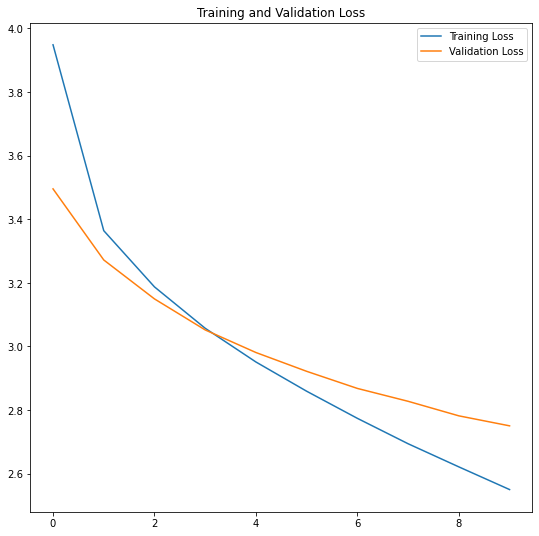

In [24]:
visualize_loss(history)

# design model with hidden layer size 2048 and learning dataset

In [27]:
hidden_size = 2048
name = "lyric_model_hidden_"+str(hidden_size)
model_hidden_2048 = LyricGenerator(tokenizer.num_words+1, embedding_size, hidden_size)

epochs = 10
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True,
        reduction="none"
    )

model_hidden_2048.compile(loss=loss,
              optimizer=optimizer)


checkpoint_dir = os.getenv("HOME")+"/github/aiffel_practice/EXPLORATION06/checkpoint/"+name
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_dir,
    save_weights_only=True,
    monitor="val_loss",
    save_best_only=True,
    mode="auto",
    verbose=1
)

history_hidden_2048 = model_hidden_2048.fit(train_dataset, epochs=epochs,
        steps_per_epoch= training_size//batch_size,
        validation_data=val_dataset,
        validation_steps=valiation_size//batch_size,
        callbacks=[cp_callback])

Epoch 1/10
274/274 [==============================] - ETA: 0s - loss: 3.8130
Epoch 00001: val_loss improved from inf to 3.32134, saving model to /home/aiffel/github/aiffel_practice/EXPLORATION06/checkpoint/lyric_model_hidden_2048
274/274 [==============================] - 240s 877ms/step - loss: 3.8130 - val_loss: 3.3213
Epoch 2/10
274/274 [==============================] - ETA: 0s - loss: 3.2010
Epoch 00002: val_loss improved from 3.32134 to 3.07866, saving model to /home/aiffel/github/aiffel_practice/EXPLORATION06/checkpoint/lyric_model_hidden_2048
274/274 [==============================] - 245s 893ms/step - loss: 3.2010 - val_loss: 3.0787
Epoch 3/10
274/274 [==============================] - ETA: 0s - loss: 2.9357
Epoch 00003: val_loss improved from 3.07866 to 2.90900, saving model to /home/aiffel/github/aiffel_practice/EXPLORATION06/checkpoint/lyric_model_hidden_2048
274/274 [==============================] - 247s 901ms/step - loss: 2.9357 - val_loss: 2.9090
Epoch 4/10
274/274 [===

In [30]:
generate_lyrics(model_hidden_2048, tokenizer, init_sentence="<start> do")

predicted :  tf.Tensor([7], shape=(1,), dtype=int64)
predicted :  tf.Tensor([86], shape=(1,), dtype=int64)
predicted :  tf.Tensor([3512], shape=(1,), dtype=int64)
predicted :  tf.Tensor([1300], shape=(1,), dtype=int64)
predicted :  tf.Tensor([6], shape=(1,), dtype=int64)
predicted :  tf.Tensor([1178], shape=(1,), dtype=int64)
predicted :  tf.Tensor([43], shape=(1,), dtype=int64)
predicted :  tf.Tensor([3], shape=(1,), dtype=int64)
reach to end token [3]
tf.Tensor([[   2   47    7   86 3512 1300    6 1178   43    3]], shape=(1, 10), dtype=int64)
2 
47 <start> 
7 <start> do 
86 <start> do you 
3512 <start> do you wanna 
1300 <start> do you wanna peek 
6 <start> do you wanna peek underneath 
1178 <start> do you wanna peek underneath the 
43 <start> do you wanna peek underneath the cover 
3 <start> do you wanna peek underneath the cover ? 


'<start> do you wanna peek underneath the cover ? <end> '

In [31]:
generate_lyrics(model_hidden_2048, tokenizer, init_sentence="<start> I want")

predicted :  tf.Tensor([10], shape=(1,), dtype=int64)
predicted :  tf.Tensor([3085], shape=(1,), dtype=int64)
predicted :  tf.Tensor([6], shape=(1,), dtype=int64)
predicted :  tf.Tensor([1063], shape=(1,), dtype=int64)
predicted :  tf.Tensor([31], shape=(1,), dtype=int64)
predicted :  tf.Tensor([9], shape=(1,), dtype=int64)
predicted :  tf.Tensor([1383], shape=(1,), dtype=int64)
predicted :  tf.Tensor([1147], shape=(1,), dtype=int64)
predicted :  tf.Tensor([3], shape=(1,), dtype=int64)
reach to end token [3]
tf.Tensor([[   2    5   62   10 3085    6 1063   31    9 1383 1147    3]], shape=(1, 12), dtype=int64)
2 
5 <start> 
62 <start> i 
10 <start> i want 
3085 <start> i want to 
6 <start> i want to diggin 
1063 <start> i want to diggin the 
31 <start> i want to diggin the scene 
9 <start> i want to diggin the scene with 
1383 <start> i want to diggin the scene with a 
1147 <start> i want to diggin the scene with a gangsta 
3 <start> i want to diggin the scene with a gangsta lean 


'<start> i want to diggin the scene with a gangsta lean <end> '

In [37]:
generate_lyrics(model_hidden_2048, tokenizer, init_sentence="<start> i love")

predicted :  tf.Tensor([7], shape=(1,), dtype=int64)
predicted :  tf.Tensor([4], shape=(1,), dtype=int64)
predicted :  tf.Tensor([51], shape=(1,), dtype=int64)
predicted :  tf.Tensor([4], shape=(1,), dtype=int64)
predicted :  tf.Tensor([30], shape=(1,), dtype=int64)
predicted :  tf.Tensor([179], shape=(1,), dtype=int64)
predicted :  tf.Tensor([5], shape=(1,), dtype=int64)
predicted :  tf.Tensor([33], shape=(1,), dtype=int64)
predicted :  tf.Tensor([7], shape=(1,), dtype=int64)
predicted :  tf.Tensor([30], shape=(1,), dtype=int64)
predicted :  tf.Tensor([179], shape=(1,), dtype=int64)
predicted :  tf.Tensor([3], shape=(1,), dtype=int64)
reach to end token [3]
tf.Tensor([[  2   5  33   7   4  51   4  30 179   5  33   7  30 179   3]], shape=(1, 15), dtype=int64)
2 
5 <start> 
33 <start> i 
7 <start> i love 
4 <start> i love you 
51 <start> i love you , 
4 <start> i love you , baby 
30 <start> i love you , baby , 
179 <start> i love you , baby , so 
5 <start> i love you , baby , so much 
3

'<start> i love you , baby , so much i love you so much <end> '

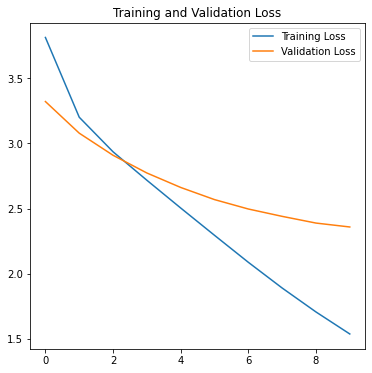

In [38]:
visualize_loss(history_hidden_2048)

# design model with hidden layer size 2048, embedding size 512 and learning dataset

In [39]:
tf.keras.backend.clear_session()

embedding_size = 512
hidden_size = 1024

weight_name = "lyric_model_embeding_"+str(embedding_size)+"_hidden_"+str(hidden_size)
model_embed_512_hidden_1024 = LyricGenerator(tokenizer.num_words+1, embedding_size, hidden_size)

epochs = 10
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True,
        reduction="none"
    )

model_embed_512_hidden_1024.compile(loss=loss,
              optimizer=optimizer)


checkpoint_dir = os.getenv("HOME")+"/github/aiffel_practice/EXPLORATION06/checkpoint/"+weight_name
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_dir,
    save_weights_only=True,
    monitor="val_loss",
    save_best_only=True,
    mode="auto",
    verbose=1
)

history_embed_512_hidden_1024 = model_embed_512_hidden_1024.fit(train_dataset, epochs=epochs,
        steps_per_epoch= training_size//batch_size,
        validation_data=val_dataset,
        validation_steps=valiation_size//batch_size,
        callbacks=[cp_callback])

Epoch 1/10
274/274 [==============================] - ETA: 0s - loss: 3.9033
Epoch 00001: val_loss improved from inf to 3.43949, saving model to /home/aiffel/github/aiffel_practice/EXPLORATION06/checkpoint/lyric_model_embeding_512_hidden_1024
274/274 [==============================] - 101s 370ms/step - loss: 3.9033 - val_loss: 3.4395
Epoch 2/10
274/274 [==============================] - ETA: 0s - loss: 3.3165
Epoch 00002: val_loss improved from 3.43949 to 3.21296, saving model to /home/aiffel/github/aiffel_practice/EXPLORATION06/checkpoint/lyric_model_embeding_512_hidden_1024
274/274 [==============================] - 102s 374ms/step - loss: 3.3165 - val_loss: 3.2130
Epoch 3/10
274/274 [==============================] - ETA: 0s - loss: 3.1203
Epoch 00003: val_loss improved from 3.21296 to 3.08376, saving model to /home/aiffel/github/aiffel_practice/EXPLORATION06/checkpoint/lyric_model_embeding_512_hidden_1024
274/274 [==============================] - 103s 376ms/step - loss: 3.1203 - v

In [45]:
generate_lyrics(model_embed_512_hidden_1024, tokenizer, init_sentence="<start> I want")

predicted :  tf.Tensor([10], shape=(1,), dtype=int64)
predicted :  tf.Tensor([27], shape=(1,), dtype=int64)
predicted :  tf.Tensor([224], shape=(1,), dtype=int64)
predicted :  tf.Tensor([3], shape=(1,), dtype=int64)
reach to end token [3]
tf.Tensor([[  2   5  62  10  27 224   3]], shape=(1, 7), dtype=int64)
2 
5 <start> 
62 <start> i 
10 <start> i want 
27 <start> i want to 
224 <start> i want to be 
3 <start> i want to be alone 


'<start> i want to be alone <end> '

In [46]:
generate_lyrics(model_embed_512_hidden_1024, tokenizer, init_sentence="<start> I love")

predicted :  tf.Tensor([7], shape=(1,), dtype=int64)
predicted :  tf.Tensor([4], shape=(1,), dtype=int64)
predicted :  tf.Tensor([5], shape=(1,), dtype=int64)
predicted :  tf.Tensor([33], shape=(1,), dtype=int64)
predicted :  tf.Tensor([7], shape=(1,), dtype=int64)
predicted :  tf.Tensor([3], shape=(1,), dtype=int64)
reach to end token [3]
tf.Tensor([[ 2  5 33  7  4  5 33  7  3]], shape=(1, 9), dtype=int64)
2 
5 <start> 
33 <start> i 
7 <start> i love 
4 <start> i love you 
5 <start> i love you , 
33 <start> i love you , i 
7 <start> i love you , i love 
3 <start> i love you , i love you 


'<start> i love you , i love you <end> '

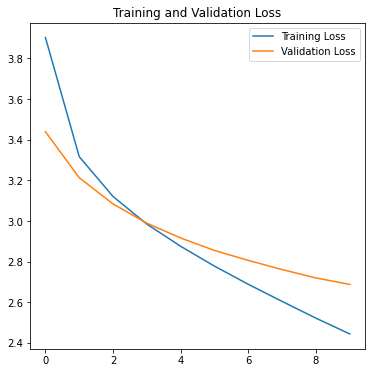

In [43]:
visualize_loss(history_embed_512_hidden_1024)

In [51]:
histories = [history, history_hidden_2048,history_embed_512_hidden_1024]
del model, model_hidden_2048, model_embed_512_hidden_1024

In [52]:
tf.keras.backend.clear_session()

embedding_size = 512
hidden_size = 2048

weight_name = "lyric_model_embeding_"+str(embedding_size)+"_hidden_"+str(hidden_size)
model_embed_512_hidden_2048 = LyricGenerator(tokenizer.num_words+1, embedding_size, hidden_size)

epochs = 10
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True,
        reduction="none"
    )

model_embed_512_hidden_2048.compile(loss=loss,
              optimizer=optimizer)


checkpoint_dir = os.getenv("HOME")+"/github/aiffel_practice/EXPLORATION06/checkpoint/"+weight_name
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_dir,
    save_weights_only=True,
    monitor="val_loss",
    save_best_only=True,
    mode="auto",
    verbose=1
)

history_embed_512_hidden_2048 = model_embed_512_hidden_2048.fit(train_dataset, epochs=epochs,
        steps_per_epoch= training_size//batch_size,
        validation_data=val_dataset,
        validation_steps=valiation_size//batch_size,
        callbacks=[cp_callback])

Epoch 1/10
274/274 [==============================] - ETA: 0s - loss: 3.9467
Epoch 00001: val_loss improved from inf to 3.48986, saving model to /home/aiffel/github/aiffel_practice/EXPLORATION06/checkpoint/lyric_model_embeding_512_hidden_2048
274/274 [==============================] - 248s 905ms/step - loss: 3.9467 - val_loss: 3.4899
Epoch 2/10
274/274 [==============================] - ETA: 0s - loss: 3.3235
Epoch 00002: val_loss improved from 3.48986 to 3.20762, saving model to /home/aiffel/github/aiffel_practice/EXPLORATION06/checkpoint/lyric_model_embeding_512_hidden_2048
274/274 [==============================] - 253s 924ms/step - loss: 3.3235 - val_loss: 3.2076
Epoch 3/10
274/274 [==============================] - ETA: 0s - loss: 3.0945
Epoch 00003: val_loss improved from 3.20762 to 3.04612, saving model to /home/aiffel/github/aiffel_practice/EXPLORATION06/checkpoint/lyric_model_embeding_512_hidden_2048
274/274 [==============================] - 255s 930ms/step - loss: 3.0945 - v

In [53]:
generate_lyrics(model_embed_512_hidden_2048, tokenizer, init_sentence="<start> I love")

predicted :  tf.Tensor([7], shape=(1,), dtype=int64)
predicted :  tf.Tensor([4], shape=(1,), dtype=int64)
predicted :  tf.Tensor([5], shape=(1,), dtype=int64)
predicted :  tf.Tensor([33], shape=(1,), dtype=int64)
predicted :  tf.Tensor([7], shape=(1,), dtype=int64)
predicted :  tf.Tensor([3], shape=(1,), dtype=int64)
reach to end token [3]
tf.Tensor([[ 2  5 33  7  4  5 33  7  3]], shape=(1, 9), dtype=int64)
2 
5 <start> 
33 <start> i 
7 <start> i love 
4 <start> i love you 
5 <start> i love you , 
33 <start> i love you , i 
7 <start> i love you , i love 
3 <start> i love you , i love you 


'<start> i love you , i love you <end> '

In [54]:
generate_lyrics(model_embed_512_hidden_2048, tokenizer, init_sentence="<start> I want")

predicted :  tf.Tensor([10], shape=(1,), dtype=int64)
predicted :  tf.Tensor([27], shape=(1,), dtype=int64)
predicted :  tf.Tensor([224], shape=(1,), dtype=int64)
predicted :  tf.Tensor([3], shape=(1,), dtype=int64)
reach to end token [3]
tf.Tensor([[  2   5  62  10  27 224   3]], shape=(1, 7), dtype=int64)
2 
5 <start> 
62 <start> i 
10 <start> i want 
27 <start> i want to 
224 <start> i want to be 
3 <start> i want to be alone 


'<start> i want to be alone <end> '

In [55]:
generate_lyrics(model_embed_512_hidden_2048, tokenizer, init_sentence="<start> do")

predicted :  tf.Tensor([7], shape=(1,), dtype=int64)
predicted :  tf.Tensor([86], shape=(1,), dtype=int64)
predicted :  tf.Tensor([65], shape=(1,), dtype=int64)
predicted :  tf.Tensor([12], shape=(1,), dtype=int64)
predicted :  tf.Tensor([11068], shape=(1,), dtype=int64)
predicted :  tf.Tensor([4], shape=(1,), dtype=int64)
predicted :  tf.Tensor([11068], shape=(1,), dtype=int64)
predicted :  tf.Tensor([4], shape=(1,), dtype=int64)
predicted :  tf.Tensor([11068], shape=(1,), dtype=int64)
predicted :  tf.Tensor([3], shape=(1,), dtype=int64)
reach to end token [3]
tf.Tensor([[    2    47     7    86    65    12 11068     4 11068     4 11068     3]], shape=(1, 12), dtype=int64)
2 
47 <start> 
7 <start> do 
86 <start> do you 
65 <start> do you wanna 
12 <start> do you wanna see 
11068 <start> do you wanna see me 
4 <start> do you wanna see me nakey 
11068 <start> do you wanna see me nakey , 
4 <start> do you wanna see me nakey , nakey 
11068 <start> do you wanna see me nakey , nakey , 
3 <s

'<start> do you wanna see me nakey , nakey , nakey <end> '

In [56]:
histories.append(history_embed_512_hidden_2048)
print(histories)

[<tensorflow.python.keras.callbacks.History object at 0x7f48262d9e90>, <tensorflow.python.keras.callbacks.History object at 0x7f4826d1c7d0>, <tensorflow.python.keras.callbacks.History object at 0x7f47a01875d0>, <tensorflow.python.keras.callbacks.History object at 0x7f4748799110>]


# visualize all history and comparison
- unfortunatly, validations loss of all models did not reach to lower bound 2.2

In [11]:
def lower_bound(x):
    return [2.2 for i in range(len(x))]

def visualize_loss_idx(history, title, idx):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]    
    epochs_range = range(len(loss))
    plt.subplot(2, 2, idx)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.plot(epochs_range, lower_bound(loss), "r--", label ="lower bound")
    plt.legend(loc='upper right')
    plt.title(title)

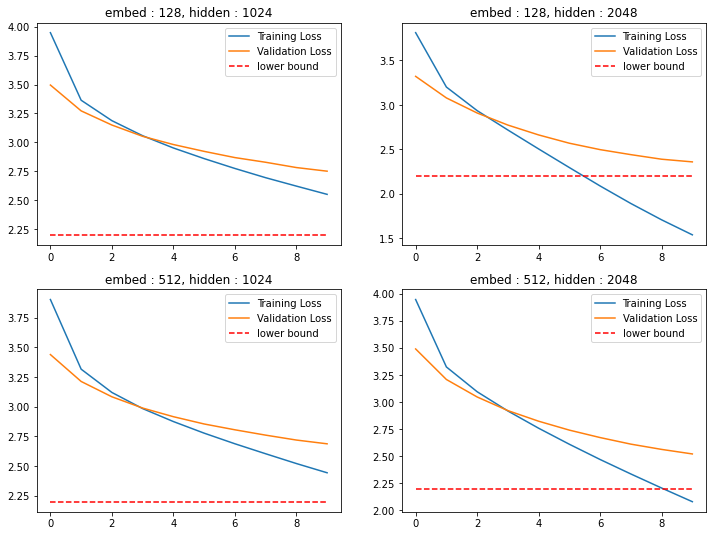

In [74]:
titles = ["embed : 128, hidden : 1024",
         "embed : 128, hidden : 2048",
         "embed : 512, hidden : 1024",
         "embed : 512, hidden : 2048"]

idx = 1
plt.figure(figsize=(12,9))
for history, title in zip(histories, titles):
    visualize_loss_idx(history, title, idx)
    idx += 1

In [77]:
class LyricGenerator2(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(LyricGenerator2, self).__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        #return_sequences means return same length of seqences with input's length
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_3 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
    
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.rnn_3(out)
        out = self.linear(out)
        return out

In [78]:
tf.keras.backend.clear_session()

embedding_size = 64
hidden_size = 512
model2_embed_64_hidden_512 = LyricGenerator2(tokenizer.num_words+1, embedding_size, hidden_size)

weight_name = "lyric_model2_embeding_"+str(embedding_size)+"_hidden_"+str(hidden_size)

epochs = 10
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True,
        reduction="none"
    )

model2_embed_64_hidden_512.compile(loss=loss,
              optimizer=optimizer)


checkpoint_dir = os.getenv("HOME")+"/github/aiffel_practice/EXPLORATION06/checkpoint/"+weight_name
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_dir,
    save_weights_only=True,
    monitor="val_loss",
    save_best_only=True,
    mode="auto",
    verbose=1
)

history2_embed_64_hidden_512 = model2_embed_64_hidden_512.fit(train_dataset, epochs=epochs,
        steps_per_epoch= training_size//batch_size,
        validation_data=val_dataset,
        validation_steps=valiation_size//batch_size,
        callbacks=[cp_callback])

Epoch 1/10
274/274 [==============================] - ETA: 0s - loss: 4.4680
Epoch 00001: val_loss improved from inf to 4.10407, saving model to /home/aiffel/github/aiffel_practice/EXPLORATION06/checkpoint/lyric_model2_embeding_64_hidden_512
274/274 [==============================] - 40s 144ms/step - loss: 4.4680 - val_loss: 4.1041
Epoch 2/10
274/274 [==============================] - ETA: 0s - loss: 4.0970
Epoch 00002: val_loss improved from 4.10407 to 4.08596, saving model to /home/aiffel/github/aiffel_practice/EXPLORATION06/checkpoint/lyric_model2_embeding_64_hidden_512
274/274 [==============================] - 40s 147ms/step - loss: 4.0970 - val_loss: 4.0860
Epoch 3/10
274/274 [==============================] - ETA: 0s - loss: 4.0463
Epoch 00003: val_loss improved from 4.08596 to 3.77076, saving model to /home/aiffel/github/aiffel_practice/EXPLORATION06/checkpoint/lyric_model2_embeding_64_hidden_512
274/274 [==============================] - 40s 146ms/step - loss: 4.0463 - val_los

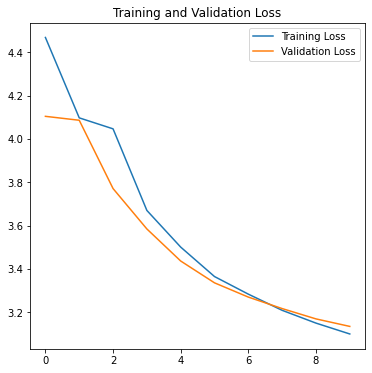

In [79]:
visualize_loss(history2_embed_64_hidden_512)

In [80]:
tf.keras.backend.clear_session()

def get_model2_history(embedding_size, hidden_size):
    model = LyricGenerator2(tokenizer.num_words+1, embedding_size, hidden_size)

    weight_name = "lyric_model2_embeding_"+str(embedding_size)+"_hidden_"+str(hidden_size)

    epochs = 10
    optimizer = tf.keras.optimizers.Adam()
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True,
            reduction="none"
        )

    model.compile(loss=loss,
                  optimizer=optimizer)


    checkpoint_dir = os.getenv("HOME")+"/github/aiffel_practice/EXPLORATION06/checkpoint/"+weight_name
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_dir,
        save_weights_only=True,
        monitor="val_loss",
        save_best_only=True,
        mode="auto",
        verbose=1
    )

    history = model.fit(train_dataset, epochs=epochs,
            steps_per_epoch= training_size//batch_size,
            validation_data=val_dataset,
            validation_steps=valiation_size//batch_size,
            callbacks=[cp_callback])
    return model, history


embedding_size = 128
hidden_size = 512
model2_embed_128_hidden_512, history2_embed_128_hidden_512 = get_model2_history(embedding_size, hidden_size)

Epoch 1/10
274/274 [==============================] - ETA: 0s - loss: 4.4376
Epoch 00001: val_loss improved from inf to 4.10830, saving model to /home/aiffel/github/aiffel_practice/EXPLORATION06/checkpoint/lyric_model2_embeding_128_hidden_512
274/274 [==============================] - 44s 162ms/step - loss: 4.4376 - val_loss: 4.1083
Epoch 2/10
274/274 [==============================] - ETA: 0s - loss: 3.9797
Epoch 00002: val_loss improved from 4.10830 to 3.79973, saving model to /home/aiffel/github/aiffel_practice/EXPLORATION06/checkpoint/lyric_model2_embeding_128_hidden_512
274/274 [==============================] - 43s 157ms/step - loss: 3.9797 - val_loss: 3.7997
Epoch 3/10
274/274 [==============================] - ETA: 0s - loss: 3.7609
Epoch 00003: val_loss improved from 3.79973 to 3.71722, saving model to /home/aiffel/github/aiffel_practice/EXPLORATION06/checkpoint/lyric_model2_embeding_128_hidden_512
274/274 [==============================] - 43s 156ms/step - loss: 3.7609 - val_

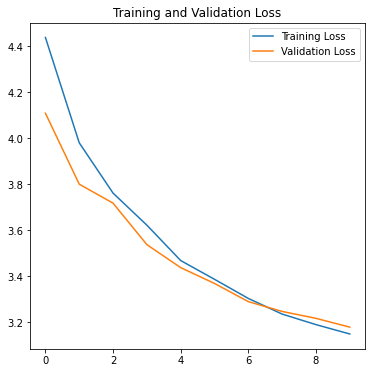

In [81]:
del model2_embed_64_hidden_512, model2_embed_128_hidden_512
visualize_loss(history2_embed_128_hidden_512)

In [18]:
class LyricGenerator3(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(LyricGenerator3, self).__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        #return_sequences means return same length of seqences with input's length
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.drop = tf.keras.layers.Dropout(0.3)
        self.batch = tf.keras.layers.BatchNormalization()
        self.linear = tf.keras.layers.Dense(vocab_size)
    
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.drop(out)
        out = self.batch(out)
        out = self.linear(out)
        return out

In [19]:
def get_model3_history(embedding_size, hidden_size):
    model = LyricGenerator3(tokenizer.num_words+1, embedding_size, hidden_size)

    weight_name = "lyric_model3_embeding_"+str(embedding_size)+"_hidden_"+str(hidden_size)

    epochs = 10
    optimizer = tf.keras.optimizers.Adam()
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True,
            reduction="none"
        )

    model.compile(loss=loss,
                  optimizer=optimizer)


    checkpoint_dir = os.getenv("HOME")+"/github/aiffel_practice/EXPLORATION06/checkpoint/"+weight_name
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_dir,
        save_weights_only=True,
        monitor="val_loss",
        save_best_only=True,
        mode="auto",
        verbose=1
    )

    history = model.fit(train_dataset, epochs=epochs,
            steps_per_epoch= training_size//batch_size,
            validation_data=val_dataset,
            validation_steps=valiation_size//batch_size,
            callbacks=[cp_callback])
    return model, history

In [20]:
tf.keras.backend.clear_session()

embedding_size = 256
hidden_size = 1024
model3_embed_256_hidden_1024, history3_embed_256_hidden_1024 = get_model3_history(embedding_size, hidden_size)

Epoch 1/10
274/274 [==============================] - ETA: 0s - loss: 3.6931
Epoch 00001: val_loss improved from inf to 4.41375, saving model to /home/aiffel/github/aiffel_practice/EXPLORATION06/checkpoint/lyric_model3_embeding_256_hidden_1024
274/274 [==============================] - 90s 330ms/step - loss: 3.6931 - val_loss: 4.4137
Epoch 2/10
274/274 [==============================] - ETA: 0s - loss: 3.0603
Epoch 00002: val_loss improved from 4.41375 to 2.99386, saving model to /home/aiffel/github/aiffel_practice/EXPLORATION06/checkpoint/lyric_model3_embeding_256_hidden_1024
274/274 [==============================] - 92s 336ms/step - loss: 3.0603 - val_loss: 2.9939
Epoch 3/10
274/274 [==============================] - ETA: 0s - loss: 2.8058
Epoch 00003: val_loss improved from 2.99386 to 2.76562, saving model to /home/aiffel/github/aiffel_practice/EXPLORATION06/checkpoint/lyric_model3_embeding_256_hidden_1024
274/274 [==============================] - 91s 330ms/step - loss: 2.8058 - v

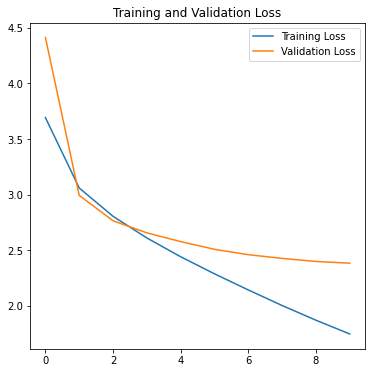

predicted :  tf.Tensor([7], shape=(1,), dtype=int64)
predicted :  tf.Tensor([169], shape=(1,), dtype=int64)
predicted :  tf.Tensor([43], shape=(1,), dtype=int64)
predicted :  tf.Tensor([47], shape=(1,), dtype=int64)
predicted :  tf.Tensor([7], shape=(1,), dtype=int64)
predicted :  tf.Tensor([169], shape=(1,), dtype=int64)
predicted :  tf.Tensor([43], shape=(1,), dtype=int64)
predicted :  tf.Tensor([47], shape=(1,), dtype=int64)
predicted :  tf.Tensor([7], shape=(1,), dtype=int64)
predicted :  tf.Tensor([169], shape=(1,), dtype=int64)
predicted :  tf.Tensor([43], shape=(1,), dtype=int64)
predicted :  tf.Tensor([3], shape=(1,), dtype=int64)
reach to end token [3]
tf.Tensor([[  2  47   7 169  43  47   7 169  43  47   7 169  43   3]], shape=(1, 14), dtype=int64)
2 
47 <start> 
7 <start> do 
169 <start> do you 
43 <start> do you mind 
47 <start> do you mind ? 
7 <start> do you mind ? do 
169 <start> do you mind ? do you 
43 <start> do you mind ? do you mind 
47 <start> do you mind ? do you 

In [22]:
visualize_loss(history3_embed_256_hidden_1024)
gen = generate_lyrics(model3_embed_256_hidden_1024, tokenizer, init_sentence="<start> do")
print(gen)
del model3_embed_256_hidden_1024 

In [23]:
tf.keras.backend.clear_session()

embedding_size = 128
hidden_size = 1024
model3_embed_128_hidden_1024, history3_embed_128_hidden_1024 = get_model3_history(embedding_size, hidden_size)

Epoch 1/10
274/274 [==============================] - ETA: 0s - loss: 3.7530
Epoch 00001: val_loss improved from inf to 4.42969, saving model to /home/aiffel/github/aiffel_practice/EXPLORATION06/checkpoint/lyric_model3_embeding_128_hidden_1024
274/274 [==============================] - 85s 312ms/step - loss: 3.7530 - val_loss: 4.4297
Epoch 2/10
274/274 [==============================] - ETA: 0s - loss: 3.1489
Epoch 00002: val_loss improved from 4.42969 to 3.07764, saving model to /home/aiffel/github/aiffel_practice/EXPLORATION06/checkpoint/lyric_model3_embeding_128_hidden_1024
274/274 [==============================] - 85s 308ms/step - loss: 3.1489 - val_loss: 3.0776
Epoch 3/10
274/274 [==============================] - ETA: 0s - loss: 2.9029
Epoch 00003: val_loss improved from 3.07764 to 2.85034, saving model to /home/aiffel/github/aiffel_practice/EXPLORATION06/checkpoint/lyric_model3_embeding_128_hidden_1024
274/274 [==============================] - 86s 312ms/step - loss: 2.9029 - v

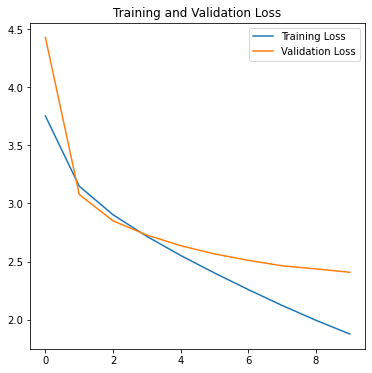

predicted :  tf.Tensor([7], shape=(1,), dtype=int64)
predicted :  tf.Tensor([34], shape=(1,), dtype=int64)
predicted :  tf.Tensor([40], shape=(1,), dtype=int64)
predicted :  tf.Tensor([5], shape=(1,), dtype=int64)
predicted :  tf.Tensor([22], shape=(1,), dtype=int64)
predicted :  tf.Tensor([646], shape=(1,), dtype=int64)
predicted :  tf.Tensor([43], shape=(1,), dtype=int64)
predicted :  tf.Tensor([3], shape=(1,), dtype=int64)
reach to end token [3]
tf.Tensor([[  2  47   7  34  40   5  22 646  43   3]], shape=(1, 10), dtype=int64)
2 
47 <start> 
7 <start> do 
34 <start> do you 
40 <start> do you know 
5 <start> do you know what 
22 <start> do you know what i 
646 <start> do you know what i m 
43 <start> do you know what i m sayin 
3 <start> do you know what i m sayin ? 
<start> do you know what i m sayin ? <end> 


In [24]:
visualize_loss(history3_embed_128_hidden_1024)
gen = generate_lyrics(model3_embed_128_hidden_1024, tokenizer, init_sentence="<start> do")
print(gen)
del model3_embed_128_hidden_1024 

In [25]:
tf.keras.backend.clear_session()

embedding_size = 256
hidden_size = 2048
model3_embed_256_hidden_2048, history3_embed_256_hidden_2048 = get_model3_history(embedding_size, hidden_size)

Epoch 1/10
274/274 [==============================] - ETA: 0s - loss: 3.6664
Epoch 00001: val_loss improved from inf to 5.58104, saving model to /home/aiffel/github/aiffel_practice/EXPLORATION06/checkpoint/lyric_model3_embeding_256_hidden_2048
274/274 [==============================] - 253s 922ms/step - loss: 3.6664 - val_loss: 5.5810
Epoch 2/10
274/274 [==============================] - ETA: 0s - loss: 3.0051
Epoch 00002: val_loss improved from 5.58104 to 3.21129, saving model to /home/aiffel/github/aiffel_practice/EXPLORATION06/checkpoint/lyric_model3_embeding_256_hidden_2048
274/274 [==============================] - 256s 935ms/step - loss: 3.0051 - val_loss: 3.2113
Epoch 3/10
274/274 [==============================] - ETA: 0s - loss: 2.7391
Epoch 00003: val_loss improved from 3.21129 to 2.74247, saving model to /home/aiffel/github/aiffel_practice/EXPLORATION06/checkpoint/lyric_model3_embeding_256_hidden_2048
274/274 [==============================] - 256s 933ms/step - loss: 2.7391 

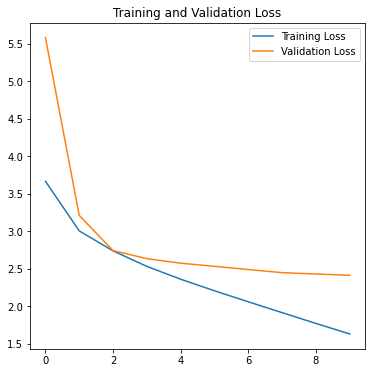

predicted :  tf.Tensor([7], shape=(1,), dtype=int64)
predicted :  tf.Tensor([313], shape=(1,), dtype=int64)
predicted :  tf.Tensor([6], shape=(1,), dtype=int64)
predicted :  tf.Tensor([73], shape=(1,), dtype=int64)
predicted :  tf.Tensor([3], shape=(1,), dtype=int64)
reach to end token [3]
tf.Tensor([[  2  47   7 313   6  73   3]], shape=(1, 7), dtype=int64)
2 
47 <start> 
7 <start> do 
313 <start> do you 
6 <start> do you remember 
73 <start> do you remember the 
3 <start> do you remember the time 
<start> do you remember the time <end> 


In [27]:
visualize_loss(history3_embed_256_hidden_2048)
gen = generate_lyrics(model3_embed_256_hidden_2048, tokenizer, init_sentence="<start> do")
print(gen)
del model3_embed_256_hidden_2048

In [28]:
tf.keras.backend.clear_session()

embedding_size = 128
hidden_size = 2048
model3_embed_128_hidden_2048, history3_embed_128_hidden_2048 = get_model3_history(embedding_size, hidden_size)

Epoch 1/10
274/274 [==============================] - ETA: 0s - loss: 3.7062
Epoch 00001: val_loss improved from inf to 5.70362, saving model to /home/aiffel/github/aiffel_practice/EXPLORATION06/checkpoint/lyric_model3_embeding_128_hidden_2048
274/274 [==============================] - 246s 898ms/step - loss: 3.7062 - val_loss: 5.7036
Epoch 2/10
274/274 [==============================] - ETA: 0s - loss: 3.0670
Epoch 00002: val_loss improved from 5.70362 to 3.31145, saving model to /home/aiffel/github/aiffel_practice/EXPLORATION06/checkpoint/lyric_model3_embeding_128_hidden_2048
274/274 [==============================] - 240s 876ms/step - loss: 3.0670 - val_loss: 3.3115
Epoch 3/10
274/274 [==============================] - ETA: 0s - loss: 2.8154
Epoch 00003: val_loss improved from 3.31145 to 2.79693, saving model to /home/aiffel/github/aiffel_practice/EXPLORATION06/checkpoint/lyric_model3_embeding_128_hidden_2048
274/274 [==============================] - 243s 887ms/step - loss: 2.8154 

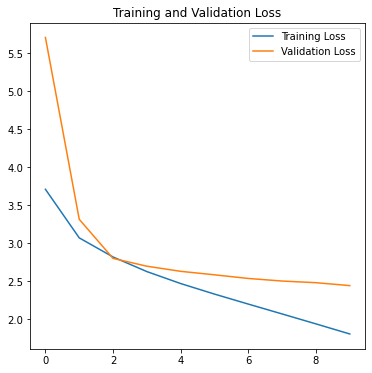

predicted :  tf.Tensor([7], shape=(1,), dtype=int64)
predicted :  tf.Tensor([156], shape=(1,), dtype=int64)
predicted :  tf.Tensor([127], shape=(1,), dtype=int64)
predicted :  tf.Tensor([19], shape=(1,), dtype=int64)
predicted :  tf.Tensor([12], shape=(1,), dtype=int64)
predicted :  tf.Tensor([46], shape=(1,), dtype=int64)
predicted :  tf.Tensor([7], shape=(1,), dtype=int64)
predicted :  tf.Tensor([335], shape=(1,), dtype=int64)
predicted :  tf.Tensor([43], shape=(1,), dtype=int64)
predicted :  tf.Tensor([3], shape=(1,), dtype=int64)
reach to end token [3]
tf.Tensor([[  2  47   7 156 127  19  12  46   7 335  43   3]], shape=(1, 12), dtype=int64)
2 
47 <start> 
7 <start> do 
156 <start> do you 
127 <start> do you ever 
19 <start> do you ever think 
12 <start> do you ever think of 
46 <start> do you ever think of me 
7 <start> do you ever think of me when 
335 <start> do you ever think of me when you 
43 <start> do you ever think of me when you lie 
3 <start> do you ever think of me when

In [29]:
visualize_loss(history3_embed_128_hidden_2048)
gen = generate_lyrics(model3_embed_128_hidden_2048, tokenizer, init_sentence="<start> do")
print(gen)
del model3_embed_128_hidden_2048

In [30]:
class LyricGenerator4(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(LyricGenerator4, self).__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        #return_sequences means return same length of seqences with input's length
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.batch = tf.keras.layers.BatchNormalization()
        self.linear = tf.keras.layers.Dense(vocab_size)
    
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.batch(out)
        out = self.linear(out)
        return out

In [41]:
histories = [history3_embed_128_hidden_1024,
            history3_embed_256_hidden_1024,
            history3_embed_128_hidden_2048,
            history3_embed_256_hidden_2048]

titles = ["model3_embed_128_hidden_1024",
            "model3_embed_256_hidden_1024",
            "model3_embed_128_hidden_2048",
            "model3_embed_256_hidden_2048"]

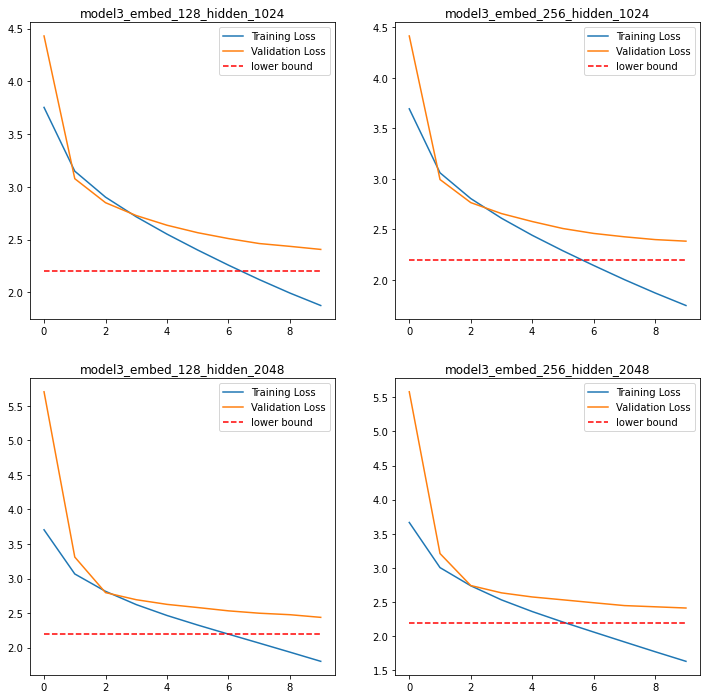

In [42]:
idx = 1
plt.figure(figsize=(12, 12))
for history, title in zip(histories, titles):
    visualize_loss_idx(history, title, idx)
    idx +=1